# <center> Proyecto Final
# <center>Análisis de Sentimiento Utilizando Métodos MCMC: Comparación del Muestreo de Gibbs con métodos alternativos.
<center> Institution: Centro de Investigación en Matemáticas A.C. 
<center> Gabriel Alejandro Aguilar Farrera  
<center> David Alejandro Muro Campa
<center> Course: Cómputo Estadístico
    

# Sección A: Usando Librerías para LDA

# Step 1.) Cargar las librerias necesarias

In [44]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
import random
from collections import defaultdict

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from gensim import corpora, models
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm  
import spacy
import re
from collections import defaultdict
from collections import Counter

# MDS librarie
import pyLDAvis.gensim

# Bag of words
from wordcloud import WordCloud

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Step 2.) Cargar la base de datos

In [2]:
df = pd.read_excel('airline.xlsx')

In [3]:
df.head(10)

,airline,overall,author,review_date,customer_review,aircraft,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Turkish Airlines,7.0,Christopher Hackley,8th May 2019,âœ… Trip Verified | London to Izmir via Istanb...,NaN,Business,Economy Class,London to Izmir via Istanbul,2019-05-01 00:00:00,4.0,5.0,4.0,4.0,2.0,4.0,yes
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Turkish Airlines,2.0,Adriana Pisoi,7th May 2019,âœ… Trip Verified | Istanbul to Bucharest. We ...,NaN,Family Leisure,Economy Class,Istanbul to Bucharest,2019-05-01 00:00:00,4.0,1.0,1.0,1.0,1.0,1.0,no
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Turkish Airlines,3.0,M Galerko,7th May 2019,âœ… Trip Verified | Rome to Prishtina via Ista...,NaN,Business,Economy Class,Rome to Prishtina via Istanbul,2019-05-01 00:00:00,1.0,4.0,1.0,3.0,1.0,2.0,no
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Turkish Airlines,10.0,Zeshan Shah,6th May 2019,âœ… Trip Verified | Flew on Turkish Airlines I...,A330,Solo Leisure,Economy Class,Washington Dulles to Karachi,April 2019,4.0,5.0,5.0,5.0,5.0,5.0,yes
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Turkish Airlines,1.0,Pooja Jain,6th May 2019,âœ… Trip Verified | Mumbai to Dublin via Istan...,NaN,Solo Leisure,Economy Class,Mumbai to Dublin via Istanbul,2019-05-01 00:00:00,1.0,1.0,1.0,1.0,1.0,1.0,no


# Step 3.) Limipar la base de datos

In [4]:
# Drop the spacing row
df.dropna(axis = 0, how = 'all', inplace = True)
df = df.dropna(subset=['customer_review'])
# Remove "Trip Verified"
df['customer_review'] = df.loc[:,'customer_review'].map(lambda exp:exp.split('| ')[1] if "Trip Verified" in exp else exp)
# Remove "not Verified"
df['customer_review'] = df.loc[:,'customer_review'].map(lambda exp:exp.split('|')[1] if 'not verified' in exp else exp)
# Remove"Verified review"
df['customer_review'] = df.loc[:,'customer_review'].map(lambda exp:exp.split('|')[1] if 'verified review' in exp else exp)
# Convert recommended columns to binary (yes=1,No=0)
df['recommended'] = df['recommended'].map({'yes':1,'no':0})
df.reset_index(level=0, inplace=True,drop=True)

In [5]:
df.head(10)

,airline,overall,author,review_date,customer_review,aircraft,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended
0,Turkish Airlines,7.0,Christopher Hackley,8th May 2019,London to Izmir via Istanbul. First time Iâ€™d...,NaN,Business,Economy Class,London to Izmir via Istanbul,2019-05-01 00:00:00,4.0,5.0,4.0,4.0,2.0,4.0,1.0
1,Turkish Airlines,2.0,Adriana Pisoi,7th May 2019,Istanbul to Bucharest. We make our check in in...,NaN,Family Leisure,Economy Class,Istanbul to Bucharest,2019-05-01 00:00:00,4.0,1.0,1.0,1.0,1.0,1.0,0.0
2,Turkish Airlines,3.0,M Galerko,7th May 2019,Rome to Prishtina via Istanbul. I flew with th...,NaN,Business,Economy Class,Rome to Prishtina via Istanbul,2019-05-01 00:00:00,1.0,4.0,1.0,3.0,1.0,2.0,0.0
3,Turkish Airlines,10.0,Zeshan Shah,6th May 2019,Flew on Turkish Airlines IAD-IST-KHI and retur...,A330,Solo Leisure,Economy Class,Washington Dulles to Karachi,April 2019,4.0,5.0,5.0,5.0,5.0,5.0,1.0
4,Turkish Airlines,1.0,Pooja Jain,6th May 2019,Mumbai to Dublin via Istanbul. Never book Turk...,NaN,Solo Leisure,Economy Class,Mumbai to Dublin via Istanbul,2019-05-01 00:00:00,1.0,1.0,1.0,1.0,1.0,1.0,0.0
5,Turkish Airlines,2.0,M Shaw,5th May 2019,Istanbul to Budapest via Dublin with Turkish A...,NaN,Couple Leisure,Economy Class,Istanbul to Budapest via Dublin,2019-05-01 00:00:00,3.0,3.0,5.0,3.0,1.0,1.0,0.0
6,Turkish Airlines,1.0,J Dalwen,2nd May 2019,"Istanbul to Algiers, planned to take off at 9:...",NaN,Business,Business Class,Istanbul to Algiers,April 2019,2.0,2.0,NaN,3.0,1.0,1.0,0.0
7,Turkish Airlines,2.0,S Gonser,29th April 2019,Basel to Cape Town via Istanbul. When I arrive...,Boeing 737-800 / A330-300,Solo Leisure,Economy Class,Basel to Cape Town via Istanbul,April 2019,3.0,3.0,2.0,3.0,1.0,2.0,0.0
8,Turkish Airlines,6.0,Sami Osman,29th April 2019,Not Verified | Abu Dhabi to Luxembourg via Ist...,A320 / Boeing 737,Solo Leisure,Economy Class,Abu Dhabi to Luxembourg via Istanbul,April 2019,2.0,3.0,3.0,3.0,3.0,3.0,1.0
9,Turkish Airlines,1.0,Norka Idalia Orlando,28th April 2019,The experience with Turkish Airlines has been ...,A320 / A330,Solo Leisure,Economy Class,Venice to Boston via Istanbul,February 2019,1.0,1.0,1.0,1.0,1.0,1.0,0.0


# Step 4.) Eliminar duplicados en la columna 'customer_review'

In [6]:
df.drop_duplicates(subset=['customer_review'],inplace=True)

In [7]:
df.reset_index(level=0, inplace=True,drop=True)

In [8]:
df.head(10)

,airline,overall,author,review_date,customer_review,aircraft,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended
0,Turkish Airlines,7.0,Christopher Hackley,8th May 2019,London to Izmir via Istanbul. First time Iâ€™d...,NaN,Business,Economy Class,London to Izmir via Istanbul,2019-05-01 00:00:00,4.0,5.0,4.0,4.0,2.0,4.0,1.0
1,Turkish Airlines,2.0,Adriana Pisoi,7th May 2019,Istanbul to Bucharest. We make our check in in...,NaN,Family Leisure,Economy Class,Istanbul to Bucharest,2019-05-01 00:00:00,4.0,1.0,1.0,1.0,1.0,1.0,0.0
2,Turkish Airlines,3.0,M Galerko,7th May 2019,Rome to Prishtina via Istanbul. I flew with th...,NaN,Business,Economy Class,Rome to Prishtina via Istanbul,2019-05-01 00:00:00,1.0,4.0,1.0,3.0,1.0,2.0,0.0
3,Turkish Airlines,10.0,Zeshan Shah,6th May 2019,Flew on Turkish Airlines IAD-IST-KHI and retur...,A330,Solo Leisure,Economy Class,Washington Dulles to Karachi,April 2019,4.0,5.0,5.0,5.0,5.0,5.0,1.0
4,Turkish Airlines,1.0,Pooja Jain,6th May 2019,Mumbai to Dublin via Istanbul. Never book Turk...,NaN,Solo Leisure,Economy Class,Mumbai to Dublin via Istanbul,2019-05-01 00:00:00,1.0,1.0,1.0,1.0,1.0,1.0,0.0
5,Turkish Airlines,2.0,M Shaw,5th May 2019,Istanbul to Budapest via Dublin with Turkish A...,NaN,Couple Leisure,Economy Class,Istanbul to Budapest via Dublin,2019-05-01 00:00:00,3.0,3.0,5.0,3.0,1.0,1.0,0.0
6,Turkish Airlines,1.0,J Dalwen,2nd May 2019,"Istanbul to Algiers, planned to take off at 9:...",NaN,Business,Business Class,Istanbul to Algiers,April 2019,2.0,2.0,NaN,3.0,1.0,1.0,0.0
7,Turkish Airlines,2.0,S Gonser,29th April 2019,Basel to Cape Town via Istanbul. When I arrive...,Boeing 737-800 / A330-300,Solo Leisure,Economy Class,Basel to Cape Town via Istanbul,April 2019,3.0,3.0,2.0,3.0,1.0,2.0,0.0
8,Turkish Airlines,6.0,Sami Osman,29th April 2019,Not Verified | Abu Dhabi to Luxembourg via Ist...,A320 / Boeing 737,Solo Leisure,Economy Class,Abu Dhabi to Luxembourg via Istanbul,April 2019,2.0,3.0,3.0,3.0,3.0,3.0,1.0
9,Turkish Airlines,1.0,Norka Idalia Orlando,28th April 2019,The experience with Turkish Airlines has been ...,A320 / A330,Solo Leisure,Economy Class,Venice to Boston via Istanbul,February 2019,1.0,1.0,1.0,1.0,1.0,1.0,0.0


# Step 5.) Preprocesamiento

In [9]:
# Cargar el modelo de spaCy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Preprocesamiento de texto con filtrado de partes del discurso
def preprocess(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV'] and not token.is_stop and token.is_alpha]

# Aplicar preprocesamiento a las reseñas
df['processed_reviews2'] = df['customer_review'].apply(preprocess)

In [10]:
df2 = df.head(50000)
df2.head(10)

,airline,overall,author,review_date,customer_review,aircraft,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended,processed_reviews2
0,Turkish Airlines,7.0,Christopher Hackley,8th May 2019,London to Izmir via Istanbul. First time Iâ€™d...,NaN,Business,Economy Class,London to Izmir via Istanbul,2019-05-01 00:00:00,4.0,5.0,4.0,4.0,2.0,4.0,1.0,"[time, d, fly, tk, find, good, air, cabin, cre..."
1,Turkish Airlines,2.0,Adriana Pisoi,7th May 2019,Istanbul to Bucharest. We make our check in in...,NaN,Family Leisure,Economy Class,Istanbul to Bucharest,2019-05-01 00:00:00,4.0,1.0,1.0,1.0,1.0,1.0,0.0,"[check, airport, luggage, gate, gate, surprise..."
2,Turkish Airlines,3.0,M Galerko,7th May 2019,Rome to Prishtina via Istanbul. I flew with th...,NaN,Business,Economy Class,Rome to Prishtina via Istanbul,2019-05-01 00:00:00,1.0,4.0,1.0,3.0,1.0,2.0,0.0,"[fly, company, time, past, year, honestly, get..."
3,Turkish Airlines,10.0,Zeshan Shah,6th May 2019,Flew on Turkish Airlines IAD-IST-KHI and retur...,A330,Solo Leisure,Economy Class,Washington Dulles to Karachi,April 2019,4.0,5.0,5.0,5.0,5.0,5.0,1.0,"[fly, return, consistently, maintain, quality,..."
4,Turkish Airlines,1.0,Pooja Jain,6th May 2019,Mumbai to Dublin via Istanbul. Never book Turk...,NaN,Solo Leisure,Economy Class,Mumbai to Dublin via Istanbul,2019-05-01 00:00:00,1.0,1.0,1.0,1.0,1.0,1.0,0.0,"[mumbai, book, turkish, airline, travel, fligh..."
5,Turkish Airlines,2.0,M Shaw,5th May 2019,Istanbul to Budapest via Dublin with Turkish A...,NaN,Couple Leisure,Economy Class,Istanbul to Budapest via Dublin,2019-05-01 00:00:00,3.0,3.0,5.0,3.0,1.0,1.0,0.0,"[delay, flight, leg, journey, stuck, hour, gro..."
6,Turkish Airlines,1.0,J Dalwen,2nd May 2019,"Istanbul to Algiers, planned to take off at 9:...",NaN,Business,Business Class,Istanbul to Algiers,April 2019,2.0,2.0,NaN,3.0,1.0,1.0,0.0,"[plan, pm, arrive, pm, night, get, announcemen..."
7,Turkish Airlines,2.0,S Gonser,29th April 2019,Basel to Cape Town via Istanbul. When I arrive...,Boeing 737-800 / A330-300,Solo Leisure,Economy Class,Basel to Cape Town via Istanbul,April 2019,3.0,3.0,2.0,3.0,1.0,2.0,0.0,"[arrive, pm, inform, departure, delay, hour, r..."
8,Turkish Airlines,6.0,Sami Osman,29th April 2019,Not Verified | Abu Dhabi to Luxembourg via Ist...,A320 / Boeing 737,Solo Leisure,Economy Class,Abu Dhabi to Luxembourg via Istanbul,April 2019,2.0,3.0,3.0,3.0,3.0,3.0,1.0,"[verify, flight, flight, comfortable, small, s..."
9,Turkish Airlines,1.0,Norka Idalia Orlando,28th April 2019,The experience with Turkish Airlines has been ...,A320 / A330,Solo Leisure,Economy Class,Venice to Boston via Istanbul,February 2019,1.0,1.0,1.0,1.0,1.0,1.0,0.0,"[experience, devastating, pay, euro, luggage, ..."


In [11]:
# Crear un diccionario de términos
dictionary = corpora.Dictionary(df2['processed_reviews2'])

# Crear el corpus
corpus = [dictionary.doc2bow(review) for review in df2['processed_reviews2']]

In [12]:
# Crear un defaultdict para almacenar las frecuencias de palabras
word_frequencies = defaultdict(int)

# Calcular las frecuencias de palabras desde el corpus
for doc in corpus:
    for word_id, freq in doc:
        word = dictionary[word_id]  # Obtener la palabra correspondiente al ID
        word_frequencies[word] += freq  # Agregar la frecuencia al diccionario de frecuencias

# Verificar las frecuencias de palabras obtenidas
#print(word_frequencies)

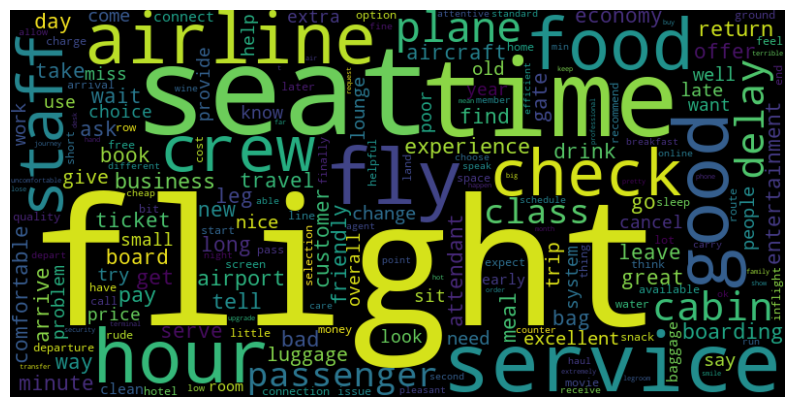

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Crear la nube de palabras con las frecuencias obtenidas
wordcloud = WordCloud(width=800, height=400, background_color='black')
wordcloud.generate_from_frequencies(word_frequencies)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('nube.png')

In [14]:
# Unir todas las palabras procesadas en un solo texto
# all_processed_words = ' '.join([word for review in df['processed_reviews2'] for word in review])

# Crear la nube de palabras con WordCloud
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_processed_words)

# Mostrar la nube de palabras
# plt.figure(figsize=(10, 6))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.title('Word Cloud - Processed Reviews')
# plt.show()

## Bolsa de palabras

In [15]:
# Entrenar el modelo LDA
num_topics = 3  # Puedes ajustar este valor según tus necesidades
lda_model = models.LdaModel(corpus, 
                            num_topics=num_topics, 
                            id2word=dictionary, 
                            passes=10, 
                            iterations=100, 
                            per_word_topics=True)

In [16]:
# Imprimir los tópicos y las palabras clave asociadas
topics = lda_model.print_topics(num_words=12)
for topic in topics:
    print(topic)

(0, '0.052*"flight" + 0.031*"good" + 0.022*"service" + 0.021*"fly" + 0.019*"food" + 0.019*"time" + 0.016*"airline" + 0.016*"crew" + 0.016*"seat" + 0.012*"cabin" + 0.012*"staff" + 0.011*"friendly"')
(1, '0.042*"seat" + 0.023*"flight" + 0.015*"meal" + 0.014*"food" + 0.013*"class" + 0.012*"serve" + 0.011*"cabin" + 0.010*"crew" + 0.010*"business" + 0.010*"drink" + 0.009*"service" + 0.009*"passenger"')
(2, '0.047*"flight" + 0.017*"hour" + 0.013*"check" + 0.013*"airline" + 0.013*"time" + 0.013*"delay" + 0.013*"fly" + 0.011*"pay" + 0.010*"tell" + 0.010*"airport" + 0.009*"bag" + 0.009*"plane"')


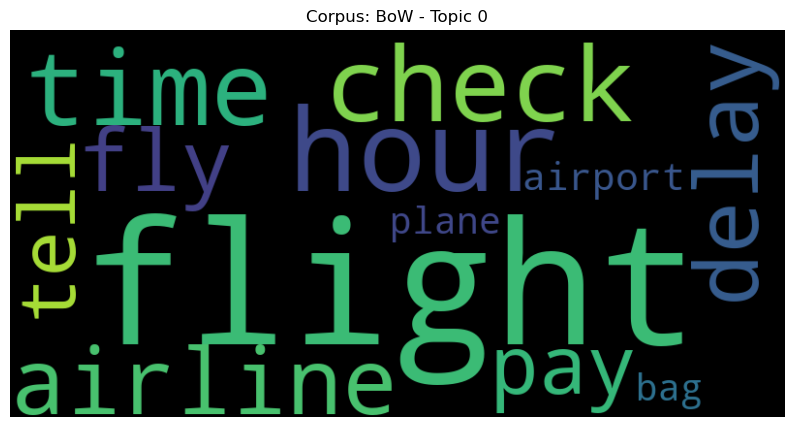

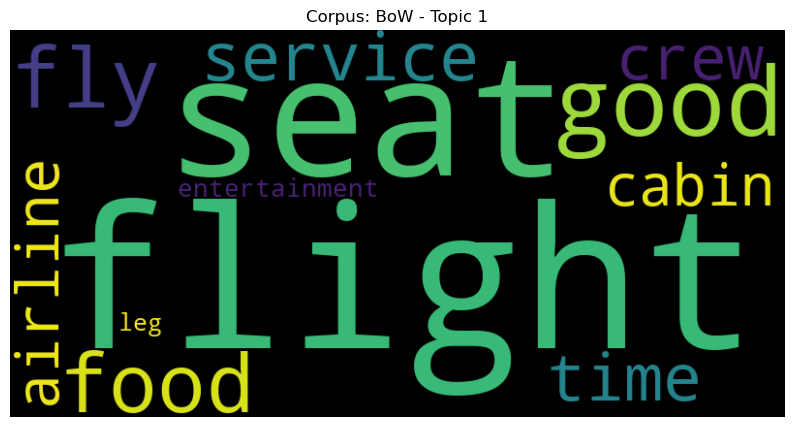

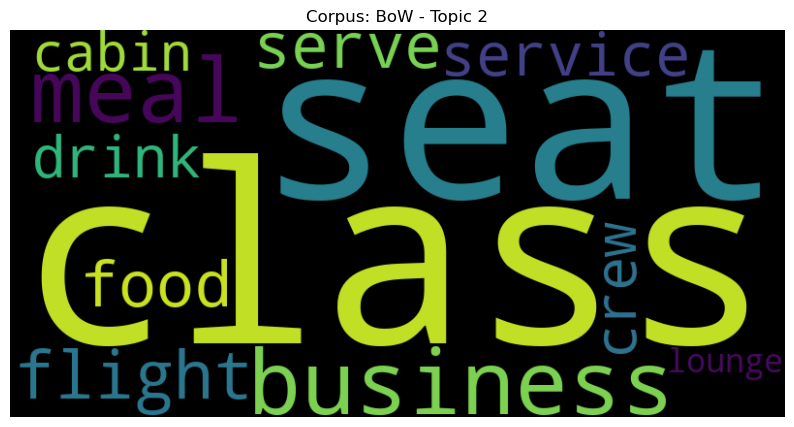

In [17]:
# Resultados del modelo LDA en el formato dado
topic_results = [
    (0, '0.047*"flight" + 0.016*"hour" + 0.013*"check" + 0.013*"time" + 0.013*"airline" + 0.012*"delay" + 0.012*"fly" + 0.011*"pay" + 0.010*"tell" + 0.010*"airport" + 0.009*"bag" + 0.009*"plane"'),
    (1, '0.049*"flight" + 0.035*"seat" + 0.025*"good" + 0.018*"fly" + 0.017*"food" + 0.017*"service" + 0.016*"time" + 0.014*"crew" + 0.013*"airline" + 0.012*"cabin" + 0.011*"entertainment" + 0.010*"leg"'),
    (2, '0.022*"class" + 0.020*"seat" + 0.019*"business" + 0.019*"meal" + 0.017*"flight" + 0.015*"food" + 0.015*"serve" + 0.013*"service" + 0.012*"drink" + 0.012*"crew" + 0.011*"cabin" + 0.011*"lounge"')
]

# Crear un diccionario para cada tópico con las palabras y sus pesos
topic_word_weights = {}
for idx, topic in topic_results:
    words = []
    weights = []
    for word_weight in topic.split("+"):
        split_word = word_weight.split("*")
        if len(split_word) == 2:
            words.append(split_word[1].replace('"', '').strip())
            weights.append(float(split_word[0]))
    word_weights = {word: weight for word, weight in zip(words, weights)}
    topic_word_weights[f"Topic {idx}"] = word_weights

# Crear una nube de palabras para cada tópico
for topic, word_weights in topic_word_weights.items():
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(word_weights)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Corpus: BoW - {topic}')
    # Guardar cada nube de palabras en una imagen separada
    plt.savefig(f'BoW_{topic}.png', bbox_inches='tight')
    plt.show()

## TF-IDF

In [18]:
model_tfidf = models.TfidfModel(corpus)
corpus_tfidf = model_tfidf[corpus]

In [19]:
num_topics = 3
lda_model_tfidf = models.LdaModel(corpus_tfidf, 
                                  num_topics=num_topics, 
                                  id2word=dictionary, 
                                  passes=10, 
                                  iterations=100,
                                  random_state=1,
                                  alpha='symmetric',
                                  update_every=1,
                                  per_word_topics=True)

In [20]:
# Imprimir los tópicos y las palabras clave asociadas
topics = lda_model_tfidf.print_topics(num_words=12)
for topic in topics:
    print(topic)

(0, '0.008*"good" + 0.007*"seat" + 0.006*"food" + 0.006*"crew" + 0.006*"cabin" + 0.005*"meal" + 0.005*"class" + 0.005*"entertainment" + 0.005*"service" + 0.005*"comfortable" + 0.005*"friendly" + 0.005*"great"')
(1, '0.007*"delay" + 0.006*"pay" + 0.006*"hour" + 0.006*"bag" + 0.006*"tell" + 0.005*"check" + 0.005*"airline" + 0.005*"airport" + 0.005*"customer" + 0.005*"day" + 0.005*"ticket" + 0.005*"luggage"')
(2, '0.011*"rouge" + 0.011*"fit" + 0.009*"kg" + 0.007*"carry" + 0.007*"size" + 0.007*"weight" + 0.007*"allowance" + 0.006*"overhead" + 0.005*"download" + 0.005*"laptop" + 0.005*"backpack" + 0.004*"compartment"')


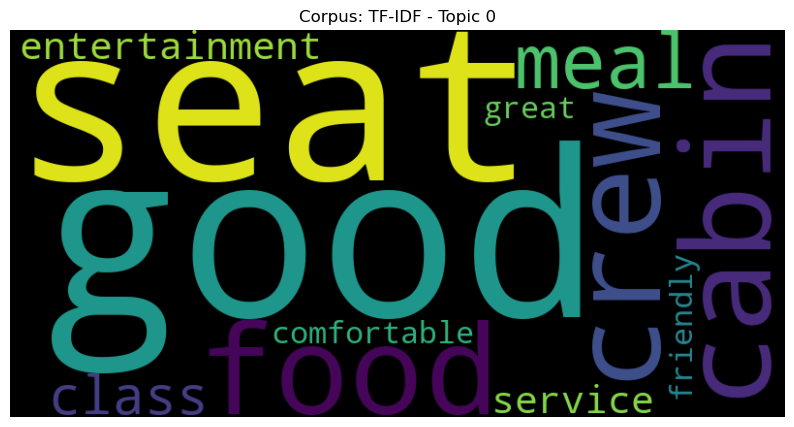

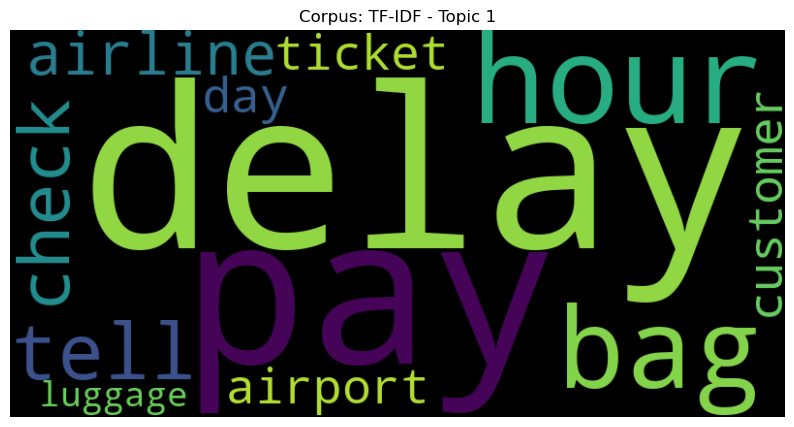

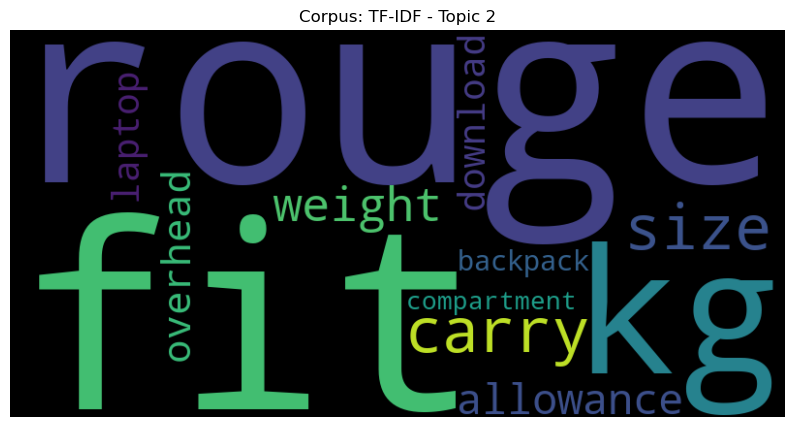

In [21]:
# Resultados del modelo LDA en el formato dado
topic_results = [
    (0, '0.008*"good" + 0.007*"seat" + 0.006*"food" + 0.006*"crew" + 0.006*"cabin" + 0.005*"meal" + 0.005*"class" + 0.005*"entertainment" + 0.005*"service" + 0.005*"comfortable" + 0.005*"friendly" + 0.005*"great"'),
    (1, '0.007*"delay" + 0.006*"pay" + 0.006*"hour" + 0.006*"bag" + 0.006*"tell" + 0.005*"check" + 0.005*"airline" + 0.005*"airport" + 0.005*"customer" + 0.005*"day" + 0.005*"ticket" + 0.005*"luggage"'),
    (2, '0.011*"rouge" + 0.011*"fit" + 0.009*"kg" + 0.007*"carry" + 0.007*"size" + 0.007*"weight" + 0.007*"allowance" + 0.006*"overhead" + 0.005*"download" + 0.005*"laptop" + 0.005*"backpack" + 0.004*"compartment"')
]

# Crear un diccionario para cada tópico con las palabras y sus pesos
topic_word_weights = {}
for idx, topic in topic_results:
    words = []
    weights = []
    for word_weight in topic.split("+"):
        split_word = word_weight.split("*")
        if len(split_word) == 2:
            words.append(split_word[1].replace('"', '').strip())
            weights.append(float(split_word[0]))
    word_weights = {word: weight for word, weight in zip(words, weights)}
    topic_word_weights[f"Topic {idx}"] = word_weights

# Crear una nube de palabras para cada tópico
for topic, word_weights in topic_word_weights.items():
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(word_weights)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Corpus: TF-IDF - {topic}')
    # Guardar cada nube de palabras en una imagen separada
    plt.savefig(f'TFIDF_{topic}.png', bbox_inches='tight')
    plt.show()

## MDS

In [22]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_tfidf, corpus_tfidf, dictionary=dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.157911 -0.137159       1        1  51.261912
1     -0.138439  0.143301       2        1  41.270499
2      0.296349 -0.006143       3        1   7.467590, topic_info=         Term         Freq        Total Category  logprob  loglift
484     carry   415.000000   415.000000  Default  30.0000  30.0000
12476   rouge   232.000000   232.000000  Default  29.0000  29.0000
2784      fit   216.000000   216.000000  Default  28.0000  28.0000
27       good  1091.000000  1091.000000  Default  27.0000  27.0000
273      tell   618.000000   618.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
248      size   140.963203   223.041914   Topic3  -4.9696   2.1357
1804   locker    50.912159    59.504555   Topic3  -5.9880   2.4386
484     carry   144.895149   415.755559   Topic3  -4.9421   1.5405
583      rule    62.440010   142.352253   Topic3  -5.7839   1.7705
1096    limit    41.718988   134.723929   Topic3  -6.1872   1.4223

[198 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
4684      3  0.985655  accommodating
541       2  0.997934          agent
84        1  0.882426       aircraft
84        2  0.116741       aircraft
66        1  0.432896        airline
...     ...       ...            ...
1171      3  0.986302          weigh
1249      3  0.991512         weight
64        1  0.863435           well
64        2  0.136743           well
839       1  0.997403           wine

[261 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [23]:
# Obtener los tópicos del modelo LDA
topics = lda_model_tfidf.print_topics(num_words=12)

# Definir una expresión regular para extraer solo palabras
word_regex = re.compile(r'\b[^\d\W]+\b')

# Listas para almacenar las palabras de cada tópico
topic_words_lists = []

# Iterar sobre los tópicos e almacenar las palabras en listas
for _, topic in topics:
    # Extraer palabras utilizando la expresión regular
    words = re.findall(word_regex, topic)
    
    # Almacenar las palabras en la lista
    topic_words_lists.append(words)

In [24]:
topico0 = topic_words_lists[0][0:5]
topico1 = topic_words_lists[1][0:5]
topico2 = topic_words_lists[2][0:5]

In [25]:
topico0

['good', 'seat', 'food', 'crew', 'cabin']

In [26]:
topico1

['delay', 'pay', 'hour', 'bag', 'tell']

In [27]:
topico2

['rouge', 'fit', 'kg', 'carry', 'size']

In [28]:
# Suponiendo que tienes un DataFrame llamado df con una columna 'preprocessed_reviews2'

# Función para asignar el label según las palabras en las listas
def asignar_label(review):
    count_topico0 = sum(palabra in review for palabra in topico0)
    count_topico1 = sum(palabra in review for palabra in topico1)
    count_topico2 = sum(palabra in review for palabra in topico2)

    if count_topico0 > count_topico1 and count_topico0 > count_topico2:
        return 0
    elif count_topico1 > count_topico0 and count_topico1 > count_topico2:
        return 1
    else:
        return 2

# Aplicar la función a la columna 'preprocessed_reviews2' y crear una nueva columna 'label'
df['label'] = df['processed_reviews2'].apply(asignar_label)


In [29]:
# Mostrar la cantidad de elementos y su frecuencia en la columna 'label'
conteo_labels = df['label'].value_counts()

# Mostrar los resultados
print(conteo_labels)

0    31633
1    17151
2    12388
Name: label, dtype: int64


In [30]:
df

,airline,overall,author,review_date,customer_review,aircraft,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended,processed_reviews2,label
0,Turkish Airlines,7.0,Christopher Hackley,8th May 2019,London to Izmir via Istanbul. First time Iâ€™d...,NaN,Business,Economy Class,London to Izmir via Istanbul,2019-05-01 00:00:00,4.0,5.0,4.0,4.0,2.0,4.0,1.0,"[time, d, fly, tk, find, good, air, cabin, cre...",0
1,Turkish Airlines,2.0,Adriana Pisoi,7th May 2019,Istanbul to Bucharest. We make our check in in...,NaN,Family Leisure,Economy Class,Istanbul to Bucharest,2019-05-01 00:00:00,4.0,1.0,1.0,1.0,1.0,1.0,0.0,"[check, airport, luggage, gate, gate, surprise...",1
2,Turkish Airlines,3.0,M Galerko,7th May 2019,Rome to Prishtina via Istanbul. I flew with th...,NaN,Business,Economy Class,Rome to Prishtina via Istanbul,2019-05-01 00:00:00,1.0,4.0,1.0,3.0,1.0,2.0,0.0,"[fly, company, time, past, year, honestly, get...",0
3,Turkish Airlines,10.0,Zeshan Shah,6th May 2019,Flew on Turkish Airlines IAD-IST-KHI and retur...,A330,Solo Leisure,Economy Class,Washington Dulles to Karachi,April 2019,4.0,5.0,5.0,5.0,5.0,5.0,1.0,"[fly, return, consistently, maintain, quality,...",0
4,Turkish Airlines,1.0,Pooja Jain,6th May 2019,Mumbai to Dublin via Istanbul. Never book Turk...,NaN,Solo Leisure,Economy Class,Mumbai to Dublin via Istanbul,2019-05-01 00:00:00,1.0,1.0,1.0,1.0,1.0,1.0,0.0,"[mumbai, book, turkish, airline, travel, fligh...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61167,Ukraine International,NaN,Yevheniy Kahanovych,21st January 2007,Two domestic flights between Kiev and Lviv las...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,"[domestic, flight, week, trouble, manual, chec...",2
61168,Ukraine International,NaN,Helen Lee,15th December 2006,I had a good flight from London to Kiev with U...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,"[good, flight, check, fast, quick, experience,...",0
61169,Ukraine International,NaN,Andriy Yesypenko,19th May 2006,Kiev - London (Gatwick) in business class (in ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,"[business, class, have, fly, time, expect, lin...",0
61170,Ukraine International,NaN,Volodya Bilotkach,29th April 2006,Several flights - KBP to AMS (3 times one way)...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,"[flight, kbp, ams, time, way, r, twice, way, m...",1


In [31]:
reviews = df['customer_review']
labels = df['label']

X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size = 0.2, random_state = 42)

In [32]:
# Vectorización TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features = 5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [33]:
rf_classifier = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf_classifier.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=42)

In [34]:
y_pred = rf_classifier.predict(X_test_tfidf)

In [35]:
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('\n Classificaion report: \n', classification_report(y_test, y_pred))

Accuracy:  0.7922353902738046

 Classificaion report: 
               precision    recall  f1-score   support

           0       0.79      0.98      0.88      6319
           1       0.78      0.89      0.83      3415
           2       0.81      0.19      0.31      2501

    accuracy                           0.79     12235
   macro avg       0.80      0.69      0.67     12235
weighted avg       0.80      0.79      0.75     12235



In [36]:
# Entrenar el clasificador de regresión logística
logistic_classifier = LogisticRegression(random_state=42)
logistic_classifier.fit(X_train_tfidf, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_logistic = logistic_classifier.predict(X_test_tfidf)

# Evaluar el modelo de regresión logística
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
classification_rep_logistic = classification_report(y_test, y_pred_logistic)

# Mostrar resultados
print('Logistic Regression Model Metrics:')
print('Accuracy: ', accuracy_logistic)
print('\nClassification report:\n', classification_rep_logistic)

Logistic Regression Model Metrics:
Accuracy:  0.8396403759705762

Classification report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92      6319
           1       0.83      0.88      0.86      3415
           2       0.69      0.51      0.58      2501

    accuracy                           0.84     12235
   macro avg       0.80      0.78      0.78     12235
weighted avg       0.83      0.84      0.83     12235



# Sección B: LDA Gibbs sampling from scratch

In [37]:
df = pd.read_excel('airline.xlsx')

In [38]:
# Drop the spacing row
df.dropna(axis = 0, how = 'all', inplace = True)
df = df.dropna(subset=['customer_review'])
# Remove "Trip Verified"
df['customer_review'] = df.loc[:,'customer_review'].map(lambda exp:exp.split('| ')[1] if "Trip Verified" in exp else exp)
# Remove "not Verified"
df['customer_review'] = df.loc[:,'customer_review'].map(lambda exp:exp.split('|')[1] if 'not verified' in exp else exp)
# Remove"Verified review"
df['customer_review'] = df.loc[:,'customer_review'].map(lambda exp:exp.split('|')[1] if 'verified review' in exp else exp)
# Convert recommended columns to binary (yes=1,No=0)
df['recommended'] = df['recommended'].map({'yes':1,'no':0})
df.reset_index(level=0, inplace=True,drop=True)

In [39]:
df.drop_duplicates(subset=['customer_review'],inplace=True)

In [40]:
df.head(10)

,airline,overall,author,review_date,customer_review,aircraft,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended
0,Turkish Airlines,7.0,Christopher Hackley,8th May 2019,London to Izmir via Istanbul. First time Iâ€™d...,NaN,Business,Economy Class,London to Izmir via Istanbul,2019-05-01 00:00:00,4.0,5.0,4.0,4.0,2.0,4.0,1.0
1,Turkish Airlines,2.0,Adriana Pisoi,7th May 2019,Istanbul to Bucharest. We make our check in in...,NaN,Family Leisure,Economy Class,Istanbul to Bucharest,2019-05-01 00:00:00,4.0,1.0,1.0,1.0,1.0,1.0,0.0
2,Turkish Airlines,3.0,M Galerko,7th May 2019,Rome to Prishtina via Istanbul. I flew with th...,NaN,Business,Economy Class,Rome to Prishtina via Istanbul,2019-05-01 00:00:00,1.0,4.0,1.0,3.0,1.0,2.0,0.0
3,Turkish Airlines,10.0,Zeshan Shah,6th May 2019,Flew on Turkish Airlines IAD-IST-KHI and retur...,A330,Solo Leisure,Economy Class,Washington Dulles to Karachi,April 2019,4.0,5.0,5.0,5.0,5.0,5.0,1.0
4,Turkish Airlines,1.0,Pooja Jain,6th May 2019,Mumbai to Dublin via Istanbul. Never book Turk...,NaN,Solo Leisure,Economy Class,Mumbai to Dublin via Istanbul,2019-05-01 00:00:00,1.0,1.0,1.0,1.0,1.0,1.0,0.0
5,Turkish Airlines,2.0,M Shaw,5th May 2019,Istanbul to Budapest via Dublin with Turkish A...,NaN,Couple Leisure,Economy Class,Istanbul to Budapest via Dublin,2019-05-01 00:00:00,3.0,3.0,5.0,3.0,1.0,1.0,0.0
6,Turkish Airlines,1.0,J Dalwen,2nd May 2019,"Istanbul to Algiers, planned to take off at 9:...",NaN,Business,Business Class,Istanbul to Algiers,April 2019,2.0,2.0,NaN,3.0,1.0,1.0,0.0
7,Turkish Airlines,2.0,S Gonser,29th April 2019,Basel to Cape Town via Istanbul. When I arrive...,Boeing 737-800 / A330-300,Solo Leisure,Economy Class,Basel to Cape Town via Istanbul,April 2019,3.0,3.0,2.0,3.0,1.0,2.0,0.0
8,Turkish Airlines,6.0,Sami Osman,29th April 2019,Not Verified | Abu Dhabi to Luxembourg via Ist...,A320 / Boeing 737,Solo Leisure,Economy Class,Abu Dhabi to Luxembourg via Istanbul,April 2019,2.0,3.0,3.0,3.0,3.0,3.0,1.0
9,Turkish Airlines,1.0,Norka Idalia Orlando,28th April 2019,The experience with Turkish Airlines has been ...,A320 / A330,Solo Leisure,Economy Class,Venice to Boston via Istanbul,February 2019,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [41]:
# Dirichlet, hyperparams, tokenizer
ALPHA      = 0.1
BETA       = 0.1
NUM_TOPICS = 3

sp         = spacy.load("en_core_web_sm")

# Reproducibility
np.random.seed(42)
random.seed(42)

In [45]:
# Hox many times this word occurs 
def generate_frecuencies(data, max_docs = 100000):
    freqs = Counter()
    all_stopwords = sp.Defaults.stop_words
    nr_tokens  = 0
    
    for doc in data[:max_docs]:
        tokens = sp.tokenizer(doc)
        for token in tokens:
            token_text = token.text.lower()
            if token_text not in all_stopwords and token.is_alpha:
                nr_tokens += 1
                freqs[token_text] += 1
    return freqs
                
    
def get_vocab(freqs, freq_threshold = 3):
    vocab = {}
    vocab_idx_str = {}
    vocab_idx = 0
    
    for word in freqs:
        if freqs[word] >= freq_threshold:
            vocab[word] = vocab_idx
            vocab_idx_str[vocab_idx] = word
            vocab_idx += 1
    return vocab, vocab_idx_str

def tokenize_dataset(data, vocab, max_docs = 100000):
    nr_tokens = 0
    nr_docs = 0
    docs = []
    
    for doc in data[:max_docs]:
        tokens = sp.tokenizer(doc)
        
        if len(tokens) > 1:
            doc = []
            for token in tokens:
                token_text = token.text.lower()
                if token_text in vocab:
                    doc.append(token_text)
                    nr_tokens += 1
            nr_docs += 1
            docs.append(doc)
    
    print(f"Number of reviews: {nr_docs}")
    print(f"Number of tokens: {nr_tokens}")
    
    # Numericalize
    corpus = []
    for doc in docs:
        corpus_d = []
        
        for token in doc:
            corpus_d.append(vocab[token])
            
        corpus.append(np.asarray(corpus_d))
        
    return docs, corpus

In [46]:
df['customer_review'] = df['customer_review'].astype(str)
data = df['customer_review'].sample(frac = 0.5, random_state = 42).values
freqs = generate_frecuencies(data)
vocab, vocab_idx_str = get_vocab(freqs)
docs, corpus = tokenize_dataset(data, vocab)
vocab_size = len(vocab)
print(f"Vocab size: {vocab_size}")

Number of reviews: 30586
Number of tokens: 1855345
Vocab size: 14304


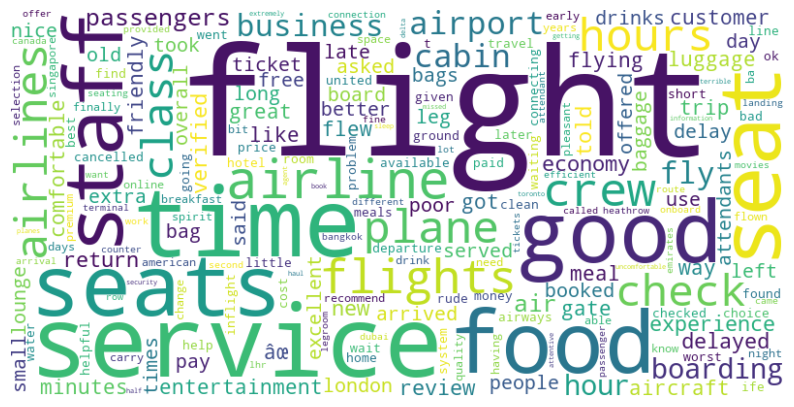

In [49]:
# Crear la instancia de WordCloud
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white')

# Generar la nube de palabras
wordcloud.generate_from_frequencies(freqs)  # 'freqs' es un diccionario con las frecuencias de las palabras

# Mostrar la nube de palabras usando Matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [51]:
def LDA_Collapsed_Gibbs(corpus, num_iter = 100):
    # Initialize counts and Z
    Z = []
    num_docs =len(corpus)
    for _, doc in enumerate (corpus):
        Zd = np.random.randint(low = 0, high = NUM_TOPICS, size = (len(doc)))
        Z.append(Zd)
        
    ndk = np.zeros((num_docs, NUM_TOPICS))
    for d in range (num_docs):
        for k in range (NUM_TOPICS):
            ndk[d, k] = np.sum(Z[d] == k)
    
    nkw =  np.zeros((NUM_TOPICS, vocab_size))
    for doc_idx, doc in enumerate (corpus):
        for i, word in enumerate(doc):
            topic = Z[doc_idx][i]
            nkw[topic, word] += 1
    
    nk = np.sum(nkw, axis = 1)
    topic_list = [i for i in range(NUM_TOPICS)]
    
    #Loop
    for _ in tqdm(range (num_iter)):
        for doc_idx, doc in enumerate(corpus):
            for i in range (len(doc)):
                word = doc[i]
                topic = Z[doc_idx][i]
                
                # Remove z_i because conditional on z_(-i)
                ndk[doc_idx, topic] -= 1
                nkw[topic, word] -= 1
                nk[topic] -= 1
                
                p_z = (ndk[doc_idx, :] + ALPHA) * (nkw[:, word] + BETA) / (nk[:] + BETA*vocab_size)
                topic = random.choices(topic_list, weights = p_z, k = 1)[0]
                
                # update n parameters
                Z[doc_idx][i] = topic
                ndk[doc_idx, topic] += 1
                nkw[topic, word]+= 1
                nk[topic] += 1
                
    return Z, ndk, nkw, nk
Z, ndk, nkw, nk = LDA_Collapsed_Gibbs(corpus)

100%|██████████| 100/100 [18:31<00:00, 11.11s/it]


In [52]:
phi = nkw/nk.reshape(NUM_TOPICS, 1) # to get the probability distribution
num_words = 10

for k in range(NUM_TOPICS):
    most_common_words = np.argsort(phi[k])[::-1][:num_words]
    print(f"Toic {k} most common words: ")
    
    for word in most_common_words:
        print(vocab_idx_str[word])
        
    print("\n")

Toic 0 most common words: 
flight
hours
time
airline
plane
airlines
told
delayed
airport
service


Toic 1 most common words: 
flight
staff
check
time
airport
airline
boarding
service
seat
seats


Toic 2 most common words: 
flight
good
food
service
class
seat
crew
seats
time
cabin


